In [80]:
import tensorflow as tf

import pandas as pd
import numpy as np

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [81]:
data = pd.read_csv('train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [82]:
cabin = data.pop('Cabin')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [83]:
tmp = data[data['Embarked'].isnull()]
tmp

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


In [84]:
data['Embarked']=data['Embarked'].fillna('C')
data[data['Fare'] == 80]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,C
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,C


In [85]:
data = data.dropna()
len(data)

714

In [86]:
data['family'] = data['SibSp'] + data['Parch']
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0


In [8]:
mean = data['Age'].median()
mean

28.0

In [9]:
data['Age'].isnull().sum()

177

In [10]:
data['Age'] = data['Age'].fillna(mean)

In [11]:
data['Age'].isnull().sum()

0

In [87]:
train, test = train_test_split(data, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

print(len(train))
print(len(val))
print(len(test))

456
115
143


In [88]:
def df_to_dataset(df, shuffle=False, batch_size=32):
    df = df.copy()
    labels = df.pop('Survived')
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    return ds

In [89]:
train_ds = df_to_dataset(train, shuffle=True)
val_ds = df_to_dataset(val)
test_ds = df_to_dataset(test)

In [105]:
feature_columns = []

for header in ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']:
    feature_columns.append(feature_column.numeric_column(header))
    
age = feature_column.numeric_column('Age')
age_buckets = feature_column.bucketized_column(age, boundaries=[10, 20, 30, 40, 50, 60, 70])
feature_columns.append(age_buckets)

sex = feature_column.categorical_column_with_vocabulary_list('Sex', ['male', 'female'])
sex_one_hot = feature_column.indicator_column(sex)
feature_columns.append(sex_one_hot)

embarked = feature_column.categorical_column_with_vocabulary_list('Embarked', ['S', 'C', 'Q'])
embarked_one_hot = feature_column.indicator_column(embarked)
feature_columns.append(embarked_one_hot)

# family = feature_column.categorical_column_with_vocabulary_list(
#         'family', data['family'].unique())
feature_columns.append(feature_column.indicator_column(family))

# ticket = feature_column.categorical_column_with_vocabulary_list(
#         'Ticket', data['Ticket'].unique())
# ticket_embedding = feature_column.embedding_column(ticket, dimension=16)
# feature_columns.append(ticket_embedding)

In [106]:
feature_layer = layers.DenseFeatures(feature_columns)

In [107]:
model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds, epochs=200)

Epoch 1/200
15/15 [==============================] - 1s 46ms/step - loss: 1.4159 - accuracy: 0.5607 - val_loss: 1.6708 - val_accuracy: 0.6522
Epoch 2/200
15/15 [==============================] - 0s 27ms/step - loss: 1.2968 - accuracy: 0.6476 - val_loss: 1.3930 - val_accuracy: 0.6174
Epoch 3/200
15/15 [==============================] - 0s 26ms/step - loss: 1.2902 - accuracy: 0.5297 - val_loss: 1.3632 - val_accuracy: 0.6783
Epoch 4/200
15/15 [==============================] - 0s 28ms/step - loss: 1.3214 - accuracy: 0.6231 - val_loss: 1.1596 - val_accuracy: 0.7043
Epoch 5/200
15/15 [==============================] - 0s 27ms/step - loss: 1.0050 - accuracy: 0.6113 - val_loss: 1.0474 - val_accuracy: 0.6435
Epoch 6/200
15/15 [==============================] - 0s 28ms/step - loss: 0.9606 - accuracy: 0.6545 - val_loss: 1.0115 - val_accuracy: 0.6696
Epoch 7/200
15/15 [==============================] - 0s 28ms/step - loss: 0.9586 - accuracy: 0.6649 - val_loss: 0.9757 - val_accuracy: 0.6783
Epoch 

Epoch 58/200
15/15 [==============================] - 0s 26ms/step - loss: 0.5344 - accuracy: 0.8304 - val_loss: 0.6632 - val_accuracy: 0.7478
Epoch 59/200
15/15 [==============================] - 0s 27ms/step - loss: 0.5495 - accuracy: 0.8131 - val_loss: 0.6520 - val_accuracy: 0.7652
Epoch 60/200
15/15 [==============================] - 0s 28ms/step - loss: 0.5407 - accuracy: 0.8355 - val_loss: 0.6612 - val_accuracy: 0.7391
Epoch 61/200
15/15 [==============================] - 0s 27ms/step - loss: 0.5505 - accuracy: 0.8252 - val_loss: 0.6466 - val_accuracy: 0.7478
Epoch 62/200
15/15 [==============================] - 0s 28ms/step - loss: 0.5149 - accuracy: 0.8340 - val_loss: 0.6369 - val_accuracy: 0.7565
Epoch 63/200
15/15 [==============================] - 0s 28ms/step - loss: 0.5274 - accuracy: 0.8227 - val_loss: 0.6422 - val_accuracy: 0.7565
Epoch 64/200
15/15 [==============================] - 0s 29ms/step - loss: 0.5453 - accuracy: 0.8277 - val_loss: 0.6354 - val_accuracy: 0.7565

15/15 [==============================] - 0s 27ms/step - loss: 0.4402 - accuracy: 0.8506 - val_loss: 0.6406 - val_accuracy: 0.7565
Epoch 116/200
15/15 [==============================] - 0s 27ms/step - loss: 0.4738 - accuracy: 0.8464 - val_loss: 0.6334 - val_accuracy: 0.7652
Epoch 117/200
15/15 [==============================] - 0s 26ms/step - loss: 0.4480 - accuracy: 0.8578 - val_loss: 0.6377 - val_accuracy: 0.7565
Epoch 118/200
15/15 [==============================] - 0s 27ms/step - loss: 0.4295 - accuracy: 0.8538 - val_loss: 0.6373 - val_accuracy: 0.7565
Epoch 119/200
15/15 [==============================] - 0s 27ms/step - loss: 0.4519 - accuracy: 0.8503 - val_loss: 0.6890 - val_accuracy: 0.7304
Epoch 120/200
15/15 [==============================] - 0s 27ms/step - loss: 0.4847 - accuracy: 0.8433 - val_loss: 0.6533 - val_accuracy: 0.7478
Epoch 121/200
15/15 [==============================] - 0s 28ms/step - loss: 0.4511 - accuracy: 0.8409 - val_loss: 0.6482 - val_accuracy: 0.7652
Epoch 

Epoch 172/200
15/15 [==============================] - 0s 27ms/step - loss: 0.4104 - accuracy: 0.8666 - val_loss: 0.6963 - val_accuracy: 0.7652
Epoch 173/200
15/15 [==============================] - 0s 27ms/step - loss: 0.4203 - accuracy: 0.8650 - val_loss: 0.7110 - val_accuracy: 0.7304
Epoch 174/200
15/15 [==============================] - 0s 27ms/step - loss: 0.4131 - accuracy: 0.8540 - val_loss: 0.6810 - val_accuracy: 0.7739
Epoch 175/200
15/15 [==============================] - 0s 27ms/step - loss: 0.4161 - accuracy: 0.8425 - val_loss: 0.6756 - val_accuracy: 0.7565
Epoch 176/200
15/15 [==============================] - 0s 27ms/step - loss: 0.3926 - accuracy: 0.8666 - val_loss: 0.6720 - val_accuracy: 0.7652
Epoch 177/200
15/15 [==============================] - 0s 27ms/step - loss: 0.3891 - accuracy: 0.8695 - val_loss: 0.7091 - val_accuracy: 0.7565
Epoch 178/200
15/15 [==============================] - 0s 27ms/step - loss: 0.4119 - accuracy: 0.8646 - val_loss: 0.7003 - val_accuracy:

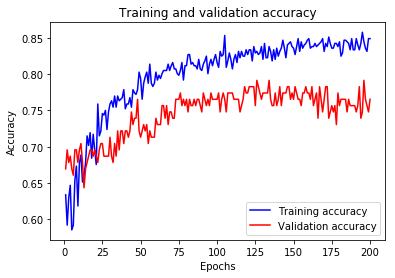

In [104]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, acc, 'b', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()